In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix


/Users/ahmed/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
merged_data = pd.read_csv("merged_data.csv")

In [3]:
from sklearn.linear_model import LogisticRegression


# Performance Rating Prediction
1- Can we predict an employee’s ManagerRating for their next performance review based on their historical ManagerRating, SelfRating, WorkLifeBalance, and TrainingOpportunitiesTaken?

In [4]:
from sklearn.linear_model import LinearRegression

X = merged_data[['SelfRating', 'WorkLifeBalance', 'TrainingOpportunitiesTaken']]
y = merged_data['ManagerRating']


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(importance)



Feature Importance:
                      Feature  Coefficient
0                  SelfRating     0.997982
2  TrainingOpportunitiesTaken     0.006081
1             WorkLifeBalance    -0.019370


/var/folders/nc/7c1k7tg930d6vjmzp7pf8yhh0000gn/T/ipykernel_15048/2891507094.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Coefficient', data=importance, palette='coolwarm')


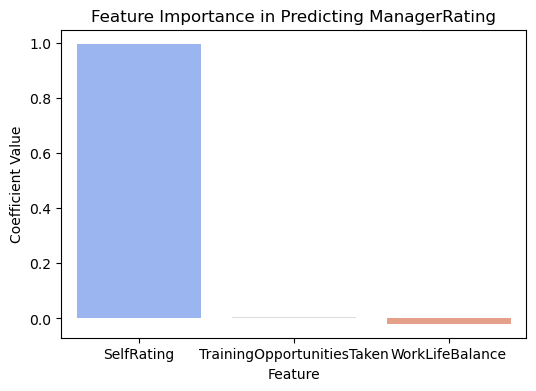

In [5]:
plt.figure(figsize=(6,4))
sns.barplot(x='Feature', y='Coefficient', data=importance, palette='coolwarm')
plt.title("Feature Importance in Predicting ManagerRating")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.show()


2- Can we forecast the average monthly ManagerRating across all employees for the next 12 months, accounting for potential seasonal trends?

In [6]:
merged_data['ReviewDate'] = pd.to_datetime(merged_data['ReviewDate'], errors='coerce')


monthly_avg = merged_data.groupby(pd.Grouper(key='ReviewDate', freq='M'))['ManagerRating'].mean().dropna()


model = SARIMAX(monthly_avg, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)


forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_avg.index[-1] + pd.offsets.MonthEnd(1),
                               periods=forecast_steps, freq='M')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


/var/folders/nc/7c1k7tg930d6vjmzp7pf8yhh0000gn/T/ipykernel_15048/3156846863.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = merged_data.groupby(pd.Grouper(key='ReviewDate', freq='M'))['ManagerRating'].mean().dropna()
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer

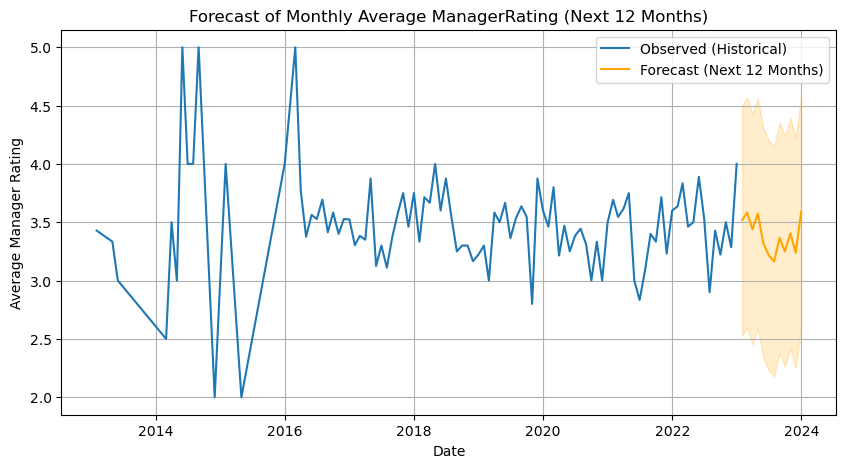


Forecasted Average ManagerRating for Next 12 Months:
         Month  Predicted_Avg_ManagerRating
97  2023-01-31                         3.52
98  2023-02-28                         3.58
99  2023-03-31                         3.44
100 2023-04-30                         3.58
101 2023-05-31                         3.32
102 2023-06-30                         3.22
103 2023-07-31                         3.16
104 2023-08-31                         3.37
105 2023-09-30                         3.25
106 2023-10-31                         3.40
107 2023-11-30                         3.24
108 2023-12-31                         3.59


In [7]:
plt.figure(figsize=(10,5))
plt.plot(monthly_avg, label='Observed (Historical)')
plt.plot(forecast_index, forecast_mean, label='Forecast (Next 12 Months)', color='orange')

plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='orange', alpha=0.2)

plt.title("Forecast of Monthly Average ManagerRating (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Average Manager Rating")
plt.legend()
plt.grid(True)
plt.show()

forecast_df = pd.DataFrame({
    'Month': forecast_index,
    'Predicted_Avg_ManagerRating': forecast_mean.round(2)
})

print("\nForecasted Average ManagerRating for Next 12 Months:")
print(forecast_df)

# Overtime Impact on Attrition

1- Can we predict the probability of an employee leaving in the next year based on their OverTime status, YearsAtCompany, DistanceFromHome, and WorkLifeBalance?


In [8]:
merged_data['AttritionFlag'] = merged_data['Attrition'].apply(
    lambda x: 1 if str(x).strip().lower() == 'yes' else 0
)
merged_data['OverTimeFlag'] = merged_data['OverTime'].apply(
    lambda x: 1 if str(x).strip().lower() == 'yes' else 0
)


X = merged_data[['OverTimeFlag', 'YearsAtCompany', 'DistanceFromHome (KM)', 'WorkLifeBalance']]
y = merged_data['AttritionFlag']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  


acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\n Feature Importance:")
print(importance)


results = X_test.copy()
results['Actual_Attrition'] = y_test.values
results['Predicted_Probability'] = y_proba.round(3)
print("\n Sample of predicted attrition probabilities:")
print(results.head(10))




 Feature Importance:
                 Feature  Coefficient
0           OverTimeFlag     1.288683
3        WorkLifeBalance     0.018580
2  DistanceFromHome (KM)    -0.004403
1         YearsAtCompany    -0.510423

 Sample of predicted attrition probabilities:
      OverTimeFlag  YearsAtCompany  DistanceFromHome (KM)  WorkLifeBalance  \
541              0               1                     28                4   
223              1               9                      7                4   
829              1               4                     40                4   
735              1               7                     36                4   
1258             0               2                     17                3   
1016             0               4                     21                4   
86               0              10                      9                3   
935              1               5                      7                4   
651              1               5     

2- Can we forecast the time until an employee leaves, focusing on the impact of OverTime, using survival analysis?


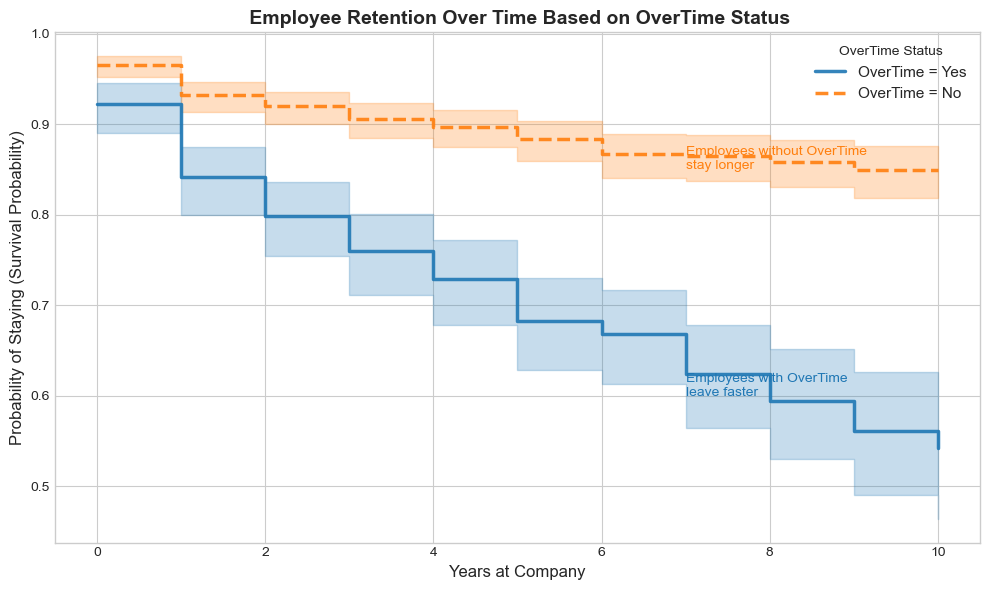

In [9]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

duration = merged_data['YearsAtCompany']
event = merged_data['AttritionFlag']
groups = merged_data['OverTimeFlag']

ix_yes = (groups == 1)
ix_no = (groups == 0)

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')

kmf = KaplanMeierFitter()

kmf.fit(duration[ix_yes], event[ix_yes], label='OverTime = Yes')
ax = kmf.plot_survival_function(
    ci_show=True, 
    linewidth=2.5, 
    color='#1f77b4', 
    linestyle='-', 
    alpha=0.9
)

kmf.fit(duration[ix_no], event[ix_no], label='OverTime = No')
kmf.plot_survival_function(
    ci_show=True, 
    linewidth=2.5, 
    color='#ff7f0e', 
    linestyle='--', 
    alpha=0.9, 
    ax=ax
)

plt.title(" Employee Retention Over Time Based on OverTime Status", fontsize=14, fontweight='bold')
plt.xlabel("Years at Company", fontsize=12)
plt.ylabel("Probability of Staying (Survival Probability)", fontsize=12)
plt.legend(title="OverTime Status", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.text(7, 0.6, 'Employees with OverTime\nleave faster', color='#1f77b4', fontsize=10)
plt.text(7, 0.85, 'Employees without OverTime\nstay longer', color='#ff7f0e', fontsize=10)

plt.tight_layout()
plt.show()


# Training Opportunities and Rating Improvement
1- Can we predict the improvement in an employee’s ManagerRating after taking training opportunities, based on TrainingOpportunitiesTaken, EducationLevel, and JobRole?

In [10]:
merged_data['ManagerRating_Improvement'] = merged_data['ManagerRating'] - merged_data['SelfRating']

le = LabelEncoder()
merged_data['JobRole_Encoded'] = le.fit_transform(merged_data['JobRole'])
merged_data['EducationLevel_Encoded'] = le.fit_transform(merged_data['EducationLevel'].astype(str))


X = merged_data[['TrainingOpportunitiesTaken', 'EducationLevel_Encoded', 'JobRole_Encoded']]
y = merged_data['ManagerRating_Improvement']

X = X.dropna()
y = y.loc[X.index]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(importance)


Feature Importance:
                      Feature  Coefficient
1      EducationLevel_Encoded     0.008740
0  TrainingOpportunitiesTaken     0.005609
2             JobRole_Encoded    -0.001942


2- Can we forecast the company-wide average ManagerRating improvement over the next 12 months, driven by increased TrainingOpportunitiesWithinYear?


/var/folders/nc/7c1k7tg930d6vjmzp7pf8yhh0000gn/T/ipykernel_15048/3993049203.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = merged_data.groupby(pd.Grouper(key='ReviewDate', freq='M')).agg({
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodel

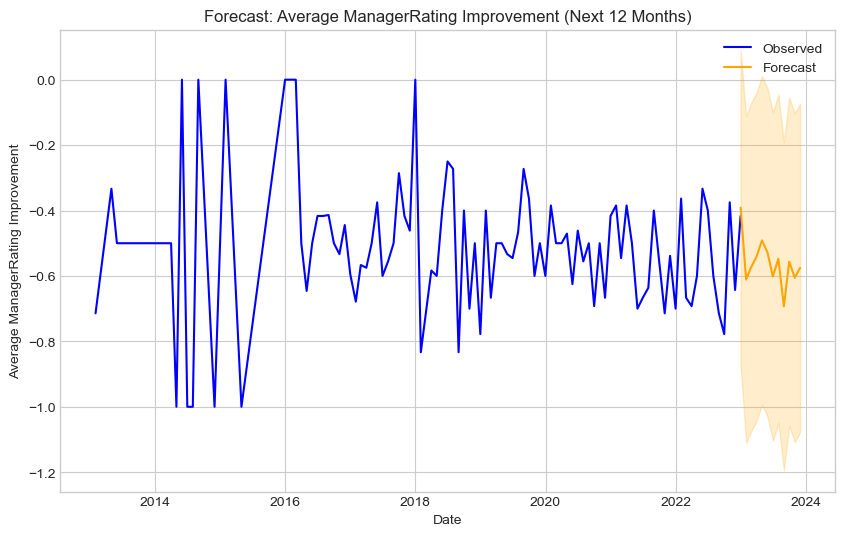


Forecasted Average ManagerRating Improvement for Next 12 Months:
97    -0.391415
98    -0.611034
99    -0.573337
100   -0.540689
101   -0.491299
102   -0.528126
103   -0.601486
104   -0.547477
105   -0.692885
106   -0.556281
107   -0.605389
108   -0.575468
Name: predicted_mean, dtype: float64


In [11]:
merged_data['ManagerRating_Improvement'] = merged_data['ManagerRating'] - merged_data['SelfRating']

merged_data['ReviewDate'] = pd.to_datetime(merged_data['ReviewDate'], errors='coerce')

merged_data = merged_data.dropna(subset=['ReviewDate'])

monthly_data = merged_data.groupby(pd.Grouper(key='ReviewDate', freq='M')).agg({
    'ManagerRating_Improvement': 'mean',
    'TrainingOpportunitiesWithinYear': 'mean'
}).reset_index()

monthly_data = monthly_data.dropna()


y = monthly_data['ManagerRating_Improvement']
X = monthly_data[['TrainingOpportunitiesWithinYear']]

model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
results = model.fit(disp=False)


future_training = pd.DataFrame({
    'TrainingOpportunitiesWithinYear': np.linspace(
        X['TrainingOpportunitiesWithinYear'].iloc[-1],
        X['TrainingOpportunitiesWithinYear'].iloc[-1] * 1.2,  
        12
    )
})

forecast = results.get_forecast(steps=12, exog=future_training)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


plt.figure(figsize=(10, 6))
plt.plot(monthly_data['ReviewDate'], y, label='Observed', color='blue')
plt.plot(pd.date_range(monthly_data['ReviewDate'].iloc[-1], periods=12, freq='M'),
         forecast_mean, label='Forecast', color='orange')

plt.fill_between(
    pd.date_range(monthly_data['ReviewDate'].iloc[-1], periods=12, freq='M'),
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange', alpha=0.2
)

plt.title("Forecast: Average ManagerRating Improvement (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Average ManagerRating Improvement")
plt.legend()
plt.grid(True)
plt.show()


print("\nForecasted Average ManagerRating Improvement for Next 12 Months:")
print(forecast_mean)

# Overall Company Attrition Rate Forecast
1- Can we forecast the monthly company-wide attrition rate for the next 12 months based on historical Attrition data aggregated by HireDate?


/var/folders/nc/7c1k7tg930d6vjmzp7pf8yhh0000gn/T/ipykernel_15048/2142318398.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_attrition = merged_data.groupby(pd.Grouper(key='HireDate', freq='M')).agg(
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ahmed/anaconda3/lib/python3.11/site-packages/statsmod

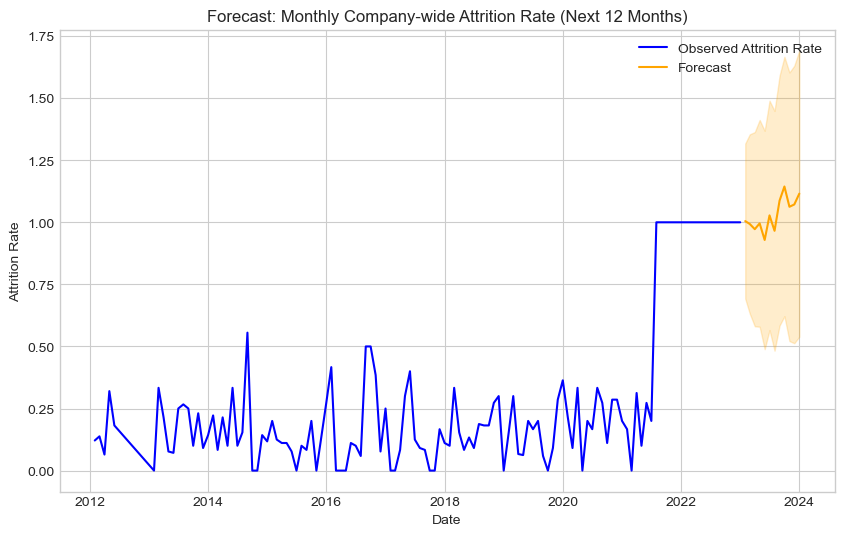


Forecasted Monthly Attrition Rate for Next 12 Months:
         Month  Forecasted_AttritionRate
124 2023-01-31                     1.005
125 2023-02-28                     0.993
126 2023-03-31                     0.972
127 2023-04-30                     0.996
128 2023-05-31                     0.929
129 2023-06-30                     1.028
130 2023-07-31                     0.966
131 2023-08-31                     1.087
132 2023-09-30                     1.144
133 2023-10-31                     1.062
134 2023-11-30                     1.072
135 2023-12-31                     1.115


In [12]:
merged_data['HireDate'] = pd.to_datetime(merged_data['HireDate'], errors='coerce')
merged_data['AttritionFlag'] = merged_data['Attrition'].apply(lambda x: 1 if str(x).strip().lower()=='yes' else 0)

merged_data = merged_data.dropna(subset=['HireDate'])

monthly_attrition = merged_data.groupby(pd.Grouper(key='HireDate', freq='M')).agg(
    AttritionRate=('AttritionFlag', 'mean')
).reset_index()

monthly_attrition = monthly_attrition.dropna()


y = monthly_attrition['AttritionRate']


model = SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)


forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_index = pd.date_range(monthly_attrition['HireDate'].iloc[-1] + pd.offsets.MonthEnd(1),
                               periods=forecast_steps, freq='M')


plt.figure(figsize=(10,6))
plt.plot(monthly_attrition['HireDate'], y, label='Observed Attrition Rate', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='orange', alpha=0.2)
plt.title("Forecast: Monthly Company-wide Attrition Rate (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Attrition Rate")
plt.legend()
plt.grid(True)
plt.show()


forecast_df = pd.DataFrame({
    'Month': forecast_index,
    'Forecasted_AttritionRate': forecast_mean.round(3)
})
print("\nForecasted Monthly Attrition Rate for Next 12 Months:")
print(forecast_df)

2- Can we predict the annual attrition rate by department for the next year, incorporating features like average Salary and WorkLifeBalance?

In [13]:
merged_data['AttritionFlag'] = merged_data['Attrition'].apply(lambda x: 1 if str(x).strip().lower()=='yes' else 0)
merged_data['HireDate'] = pd.to_datetime(merged_data['HireDate'], errors='coerce')
merged_data['Year'] = merged_data['HireDate'].dt.year

annual_data = merged_data.groupby(['Year', 'Department']).agg(
    AttritionRate=('AttritionFlag', 'mean'),
    AvgSalary=('Salary', 'mean'),
    AvgWorkLifeBalance=('WorkLifeBalance', 'mean')
).reset_index()


predictions = []

departments = annual_data['Department'].unique()
for dept in departments:
    dept_data = annual_data[annual_data['Department'] == dept]
    
    X = dept_data[['AvgSalary', 'AvgWorkLifeBalance']]
    y = dept_data['AttritionRate']
    
    model = LinearRegression()
    model.fit(X, y)
    
    last_year_data = X.iloc[-1].values.reshape(1, -1)
    predicted_attrition = model.predict(last_year_data)[0]
    
    predictions.append({
        'Department': dept,
        'Predicted_AttritionRate_NextYear': round(predicted_attrition, 3)
    })


forecast_df = pd.DataFrame(predictions)
print("\nPredicted Annual Attrition Rate by Department for Next Year:")
print(forecast_df)


Predicted Annual Attrition Rate by Department for Next Year:
        Department  Predicted_AttritionRate_NextYear
0  Human Resources                             0.626
1            Sales                             0.351
2       Technology                             0.780
